**The purpose is to build a decision tree to classify the Iris dataset.**

# Import necessary libraries

In [76]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Load Iris dataset

In [77]:
data = load_iris()
df = pd.DataFrame(data.data,columns=data.feature_names)
df['species'] = data.target #{0: 'setosa', 1: 'versicolor', 2: 'virginica'}
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Data preprocessing

In [78]:
df.drop_duplicates(inplace=True)

In [79]:
df.dropna(inplace = True)

# Building the Decision Tree Model from Scratch (OOP)

In [80]:
class Node():
  def __init__(self ,feature_index = None ,threshold = None ,left = None ,right = None ,info_gain = None, value = None ):

    #desicion part
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.info_gain = info_gain

    #leaf
    self.value = value

In [81]:
class Classifier():
  def __init__(self, min_samp_split = 2, max_depth  = 2):

    self.root = None
    #stop conditions for recursion
    self.min_samp_split = min_samp_split
    self.max_depth = max_depth

  def build(self, data , curr_depth = 0):
    X, Y = data[:,:-1], data[:,-1]
    nsamples , nfeatures = np.shape(X)

    #build using recursion till stop condition asre satisfied
    if nsamples >= self.min_samp_split and curr_depth <= self.max_depth:
      #finding best split
      best_split = self.get_best_split(data, nsamples , nfeatures)

      if best_split['info_gain'] > 0:

        left_subtree =self.build(best_split['data_left'], curr_depth + 1)
        right_subtree =self.build(best_split['data_right'], curr_depth + 1)

        #desicion node
        return Node(best_split["feature_index"], best_split['threshold'], left_subtree, right_subtree, best_split['info_gain'])

    #leaf
    leaf_value = self.calculate_leaf_value(Y)

    return Node(value = leaf_value)

  def get_best_split(self , data, nsamples, nfeatures):

    best_split = {}
    max_info_gain = -float('inf')

    for feature_index in range(nfeatures):

      feature_values = data[:,feature_index]
      possible_thresholds = np.unique(feature_values)

      for threshold in possible_thresholds:

        data_left, data_right = self.split(data, feature_index, threshold)

        if len(data_left) > 0 and len(data_right) > 0:
          y, left_y, right_y = data[:,-1], data_left[:,-1], data_right[:,-1]

          curr_info_gain = self.information_gain(y,left_y, right_y, "gini")

          if curr_info_gain >max_info_gain:
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["data_left"] = data_left
            best_split["data_right"] = data_right
            best_split["info_gain"] = curr_info_gain
            max_info_gain = curr_info_gain

    return best_split

  def split(self, data, feature_index, threshold):

    data_left = np.array([row for row in data if row[feature_index] <= threshold])
    data_right = np.array([row for row in data if row[feature_index] > threshold])

    return data_left, data_right

  def information_gain(self, parent, lchild, rchild, mode = "entropy"):

    weightleft = len(lchild) / len(parent)
    weightright = len(rchild) / len(parent)

    if mode =="gini":
      gain = self.gini_index(parent) - (weightleft*self.gini_index(lchild) + weightright*self.gini_index(rchild))
    else:
      gain = self.entropy(parent) - (weightleft*self.entropy(lchild) + weightright*self.entropy(rchild))

    return gain

  def entropy(self, y):

    class_labels = np.unique(y)
    entropy = 0

    for label in class_labels:

      p_class = len(y[y==label])/len(y)
      entropy += -p_class*np.log2(p_class)

    return entropy

  def gini_index(self,y):

    class_labels = np.unique(y)
    gini = 0

    for label in class_labels:

      p_class = len(y[y==label])/len(y)
      gini += -p_class*np.log2(p_class)

    return gini

  def calculate_leaf_value(self, y):

    y = list(y)

    return max(y,key = y.count)

  def print_tree(self, tree = None, indent = ' '):

    if not tree:
      tree = self.root

    if tree.value is not None:
      print(tree.value)

    else:
      print("X_"+str(tree.feature_index), "<=", tree.threshold, '?', tree.info_gain)
      print('%sleft:'% (indent), end = '')
      self.print_tree(tree.left,indent+indent)
      print('%sright:'% (indent), end = '')
      self.print_tree(tree.right,indent+indent)

  def fit(self, X, Y):

    data = np.concatenate((X,Y), axis = 1)
    self.root = self.build(data)

  def predict(self, X):
    return [self.make_prediction(x, self.root) for x in X]

  def make_prediction(self, x, tree):

    if tree.value != None: return tree.value

    feature_val = x[tree.feature_index]

    if feature_val <= tree.threshold:
      return self.make_prediction(x, tree.left)
    else:
      return self.make_prediction(x, tree.right)


# Prepare data

In [82]:
X = df.iloc[:,:-1].values# returns np array
Y = df.iloc[:,-1].values.reshape(-1,1)

In [83]:
#Split into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

# Initialize the decision tree model and see the result

In [84]:
model = Classifier(min_samp_split=2,max_depth=2)
model.fit(X_train, Y_train)
model.print_tree()

X_2 <= 1.9 ? 0.9366673818775625
 left:0.0
 right:X_3 <= 1.7 ? 0.845401027654467
  left:X_2 <= 5.0 ? 0.20732243629500724
    left:1.0
    right:2.0
  right:2.0


In [85]:
Y_pred = model.predict(X_test)
accuracy_score(Y_test, Y_pred)# 90%

0.9

#Comparison

In [94]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

In [87]:
sklearn_model = DecisionTreeClassifier(max_depth=2, random_state=41)
sklearn_model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=2, random_state=41)

In [88]:
Y_pred_sklearn = sklearn_model.predict(X_test)
accuracy_score(Y_test, Y_pred_sklearn)

0.8666666666666667

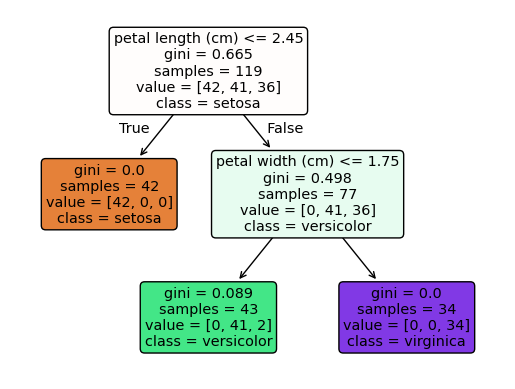

In [93]:
plot_tree(sklearn_model, filled=True, feature_names=data.feature_names, class_names=data.target_names, rounded=True)
plt.show()